# 1.Install Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp


# 2.Keypoints using MP Holistic

In [8]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 

In [4]:
def mediapipe_detection(image, model):
    
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    image.flags.writeable = False 
    
    results = model.process(image)   
    
    image.flags.writeable = True    
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results


In [5]:
def draw_landmarks(image, results):
    
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) 
    
     # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 
    

In [6]:
def draw_styled_landmarks(image, results):
    
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
    

### Access WebCam Using OpenCV

In [9]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        
        draw_styled_landmarks(image, results)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()  

In [10]:
len(results.left_hand_landmarks.landmark)

21

In [11]:
results

mediapipe.python.solution_base.SolutionOutputs

In [12]:
draw_landmarks(frame, results)

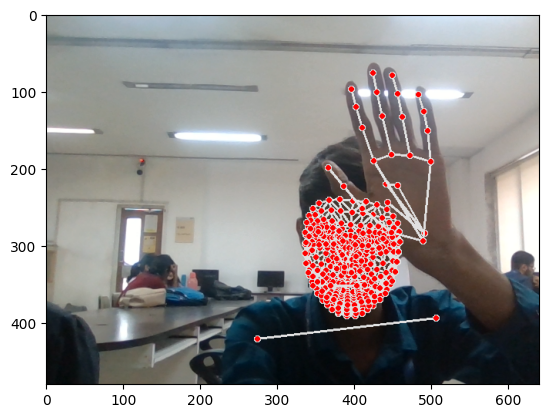

In [13]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [14]:
len(results.left_hand_landmarks.landmark)

21

In [15]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)
    

In [16]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)


In [17]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)


In [18]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [19]:
result_test = extract_keypoints(results)


In [20]:
result_test

array([ 0.60553217,  0.68480033, -0.63985753, ...,  0.        ,
        0.        ,  0.        ])

In [21]:
np.save('0', result_test)

In [22]:
np.load('0.npy')

array([ 0.60553217,  0.68480033, -0.63985753, ...,  0.        ,
        0.        ,  0.        ])

# Setup Folders for Collection

In [23]:
DATA_PATH = os.path.join('MP_Data_Set') 
dict={"hello":1}

actions = np.array(['hello' , 'thanks', 'iloveyou'])

no_sequences = 30

sequence_length = 30

In [24]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collect Keypoint Values for Training and Testing

In [68]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     NEW LOOP
#     Loop through actions
    for action in actions:
#         Loop through sequences aka videos
        for sequence in range(no_sequences):
#             Loop through video length aka sequence length
            for frame_num in range(sequence_length):

#                 Read feed
                ret, frame = cap.read()

#                 Make detections
                image, results = mediapipe_detection(frame, holistic)
                print(results)

#                 Draw landmarks
                draw_styled_landmarks(image, results)
                
#                 NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
#                 NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()
    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

KeyboardInterrupt: 

In [26]:
cap.release()
cv2.destroyAllWindows()

# Preprocess Data and Create Labels 

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [28]:
label_map = {label:num for num, label in enumerate(actions)}


In [29]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [30]:
actions

array(['hello', 'thanks', 'iloveyou'], dtype='<U8')

In [31]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = [] 
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [32]:
np.array(sequences).shape

(90, 30, 1662)

In [33]:
np.array(labels).shape

(90,)

In [34]:
X = np.array(sequences)

In [35]:
X.shape

(90, 30, 1662)

In [36]:
y = to_categorical(labels).astype(int)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)


In [38]:
X_train.shape

(85, 30, 1662)

In [39]:
X_test.shape

(5, 30, 1662)

In [40]:
y_train.shape

(85, 3)

In [41]:
y_test[3]

array([0, 1, 0])

# Build and Train LSTM Neural Network

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard


In [43]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)


In [44]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [45]:
res = [0, 1, 0, 0, 0, 0, 0]

In [47]:
actions[np.argmax(y_test[4])]

'iloveyou'

In [48]:
y_test

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [49]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [50]:
 model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback],batch_size=30)

Epoch 1/500
3/3 [==============================] - 12s 323ms/step - loss: 1.1921 - categorical_accuracy: 0.1882
Epoch 2/500
3/3 [==============================] - 1s 303ms/step - loss: 5.2446 - categorical_accuracy: 0.3412
Epoch 3/500
3/3 [==============================] - 1s 338ms/step - loss: 1.5816 - categorical_accuracy: 0.3882
Epoch 4/500
3/3 [==============================] - 1s 332ms/step - loss: 1.1851 - categorical_accuracy: 0.4118
Epoch 5/500
3/3 [==============================] - 1s 314ms/step - loss: 2.3374 - categorical_accuracy: 0.4000
Epoch 6/500
3/3 [==============================] - 1s 367ms/step - loss: 1.2190 - categorical_accuracy: 0.5412
Epoch 7/500
3/3 [==============================] - 1s 331ms/step - loss: 1.9649 - categorical_accuracy: 0.3176
Epoch 8/500
3/3 [==============================] - 1s 324ms/step - loss: 1.1286 - categorical_accuracy: 0.3412
Epoch 9/500
3/3 [==============================] - 1s 327ms/step - loss: 1.0404 - categorical_accuracy: 0.4000


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

In [52]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


1/1 [==============================] - 1s 1s/step - loss: 0.0095 - categorical_accuracy: 1.0000
Test loss: 0.00946140382438898
Test accuracy: 1.0


# Make Predictions

In [53]:
res = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [54]:
actions[np.argmax(res[1])]

'hello'

In [55]:
actions[np.argmax(y_test[1])]

'hello'

In [56]:
model.save('action.h5')

In [57]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [58]:
ypred = model.predict(X_test)

1/1 [==============================] - 0s 88ms/step


In [59]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [60]:
multilabel_confusion_matrix(ytrue, ypred)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [61]:
accuracy_score(ytrue, ypred)

1.0

In [62]:
colors=[(245,117,16), (117,245,16), (16,117,245), (117,16,245)]
def prob_viz(res,actions,input_frame,colors):
    output_frame=input_frame.copy()
    for num,prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return output_frame

In [66]:
sequence=[]
sentence=[]
predictions=[]
threshold=0.5
cap=cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret,frame=cap.read()
        image,results=mediapipe_detection(frame,holistic)
        draw_styled_landmarks(image,results)
        
        keypoints=extract_keypoints(results)
        sequence.append(keypoints)
        sequence=sequence[-30:]
        if len(sequence)==30:
            res=model.predict(np.expand_dims(sequence,axis=0))[0]
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)]>threshold:
                    if len(sentence)>0:
                        if actions[np.argmax(res)]!=sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
            if len(sentence)>5:
                sentence=sentence[-5:]
            image=prob_viz(res,actions,image,colors)
        cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
        cv2.putText(image,' '.join(sentence),(3,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        cv2.imshow("Frame",image)
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 50ms/step


In [67]:
cap.release()
cv2.destroyAllWindows()